## Final Project Submission

Please fill out:
* Student name: Seyma Tas
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: Amber Yandow
* Blog post URL:


In [56]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ParameterGrid
from sklearn.linear_model import LogisticRegression, SGDClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.metrics import recall_score, f1_score, fbeta_score, r2_score, roc_auc_score, roc_curve, auc, cohen_kappa_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
import xgboost as xgb
# from sklearn.metrics import plot_confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [39]:
df = pd.read_csv('TelcoCustomerChurnData_cleaned_ohe.csv')

In [40]:
df.head()

,tenure,MonthlyCharges,TotalCharges,Churn,SeniorCitizen_1,Partner_Yes,Dependents_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,...,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,0,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
1,34,56.95,1889.50,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,2,53.85,108.15,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,45,42.30,1840.75,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0
4,2,70.70,151.65,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0


# Splitting the data into test and train sets

In [41]:
X = df.drop(['Churn'], axis=1)
y = df['Churn']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [43]:
scaler = StandardScaler()
scaled_x_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)
scaled_X_train = pd.DataFrame(scaled_x_train, columns=X_train.columns)


## Functions to evaluate the model

In [44]:
def roc_curve_and_auc(clf, X_train, X_test, y_train, y_test):

    # Calculate the probability scores of each point in the training set
    y_train_score = clf.fit(X_train, y_train).decision_function(X_train)

    # Calculate the fpr, tpr, and thresholds for the training set
    train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)

    # Calculate the probability scores of each point in the test set
    y_test_score = clf.decision_function(X_test)

    # Calculate the fpr, tpr, and thresholds for the test set
    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)

    # ROC curve for training set
    plt.figure(figsize=(10, 8))
    lw = 2
    plt.plot(train_fpr, train_tpr, color='darkorange',
             lw=lw, label='Train ROC curve')
    plt.plot(test_fpr, test_tpr, color='blue',
             lw=lw, label='Test ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve for Training and Testing Sets')
    plt.legend(loc='lower right')
    plt.show()
    # Print the area under the roc curve
    print('Training AUC: {}'.format(round(auc(train_fpr, train_tpr), 5)))
    print('Testing AUC: {}'.format(round(auc(test_fpr, test_tpr), 5)))

In [45]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

In [46]:
 def confusion_matrix_df(y_test, y_pred_test):
    confusion_mat = confusion_matrix(y_test, y_pred_test, labels=[0, 1])
    _row = confusion_mat.sum(axis=0)
    _col = [np.nan] + list(confusion_mat.sum(axis=1)) + [sum(_row)]
    con_df = pd.DataFrame({})
    con_df["Predicted"] = ["Actual"] + ["No Churn", "Churn"] + ["All"]
    for label, idx in {"No Churn": 0, "Churn": 1}.items():
        temp = [np.nan] + list(confusion_mat[:, idx]) + [_row[idx]]
        con_df[label] = temp

    con_df["All"] = _col
    print(con_df)

In [ ]:
# # Plot features importances metric evaluation fonksiyonuna bunu ekleyecegim
# imp = pd.Series(data=clf.feature_importances_, index=x.columns).sort_values(ascending=False)
# plt.figure(figsize=(10,12))
# plt.title("Feature importance")
# ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')

In [47]:
def model_evaluation(X_train, X_test, y_train, y_test, y_pred_train, y_pred_test):

    print('MODEL EVALUATION METRICS:\n',
          '-----------------------------------------------------')
    
    print('Confusion Matrix for train & test set: \n')
    print(confusion_matrix_df(y_train, y_pred_train), '\n')
    print(confusion_matrix_df(y_test, y_pred_test),'\n')
   
    print('-----------------------------------------------------')
    print('\nClassification Report for train & test set\n',
          '\nTrain set\n',
          classification_report(y_train, y_pred_train),
          '\n\nTest set\n',
          classification_report(y_test, y_pred_test))

    print('-----------------------------------------------------\n')
    print("Cohen's Kappa for train and test set:\n ",
            round(cohen_kappa_score(y_train, y_pred_train), 4),
            round(cohen_kappa_score(y_test, y_pred_test), 4))

    print ("f2 score for train and test set: \n ",
           round(fbeta_score(y_train, y_pred_train, 2.0),4), 
           round(fbeta_score(y_test, y_pred_test, 2.0),4))
    
    print ('roc auc score for train and test set:\n ', 
           round(roc_auc_score(y_train, y_pred_train),4),
           round(roc_auc_score(y_test, y_pred_test),4) )
    
    print('Mean Cross Validation Score:\n', round(cross_val_score(clf, X, y, cv=5).mean(), 4))   

## Handling Imbalanced Data

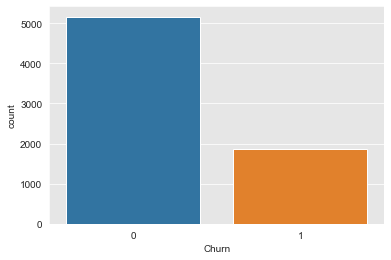

In [48]:
sns.countplot(y);

In [49]:
print(y.value_counts())
print(y.value_counts(normalize=True))

0    5163
1    1869
Name: Churn, dtype: int64
0    0.734215
1    0.265785
Name: Churn, dtype: float64


## SMOTE


In [50]:
smote = SMOTE()
scaled_X_train_smoted, y_train_smoted = smote.fit_sample(scaled_X_train, y_train)

In [51]:
# smote = SMOTE()
# X_train_smoted, y_train_smoted = smote.fit_sample(X_train, y_train)

## ADASYN

In [52]:
adasyn = ADASYN()

In [53]:
X_train_ada, y_train_ada = adasyn.fit_sample(X_train, y_train)

# RANDOM FOREST baseline


In [66]:
clf = RandomForestClassifier(random_state=123)
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [67]:
model_evaluation(X_train, X_test, y_train, y_test, y_pred_train, y_pred_test)

MODEL EVALUATION METRICS:
 -----------------------------------------------------
Confusion Matrix for train & test set: 

  Predicted  No Churn   Churn     All
0    Actual       NaN     NaN     NaN
1  No Churn    3851.0    12.0  3863.0
2     Churn      74.0  1337.0  1411.0
3       All    3925.0  1349.0  5274.0
None 

  Predicted  No Churn  Churn     All
0    Actual       NaN    NaN     NaN
1  No Churn    1149.0  151.0  1300.0
2     Churn     253.0  205.0   458.0
3       All    1402.0  356.0  1758.0
None 

-----------------------------------------------------

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3863
           1       0.99      0.95      0.97      1411

    accuracy                           0.98      5274
   macro avg       0.99      0.97      0.98      5274
weighted avg       0.98      0.98      0.98      5274
 

Test set
               precision    recall  f1-s

In [68]:
# roc_curve_and_auc(clf, X_train, X_test, y_train, y_test)

In [69]:
clf.feature_importances_.round(5)

array([0.17235, 0.19032, 0.2321 , 0.02336, 0.02382, 0.02097, 0.0068 ,
       0.0227 , 0.0269 , 0.00993, 0.00233, 0.02155, 0.00456, 0.02119,
       0.01228, 0.02299, 0.00712, 0.01958, 0.02535, 0.03757, 0.02715,
       0.01316, 0.04407, 0.01185])

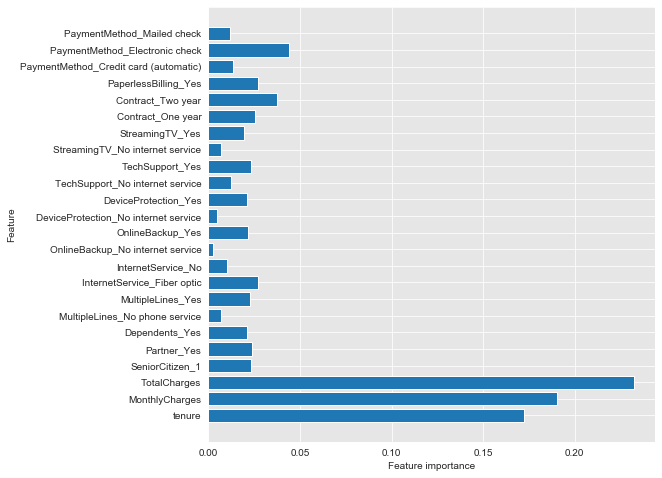

In [71]:
plot_feature_importances(clf)

# RANDOM FOREST smoted

In [72]:
clf = RandomForestClassifier(random_state=123)
clf.fit(scaled_X_train_smoted, y_train_smoted)
y_pred_train = clf.predict(scaled_X_train_smoted)
y_pred_test = clf.predict(scaled_X_test)

In [73]:
model_evaluation(scaled_X_train_smoted, scaled_X_test, y_train_smoted, y_test, y_pred_train, y_pred_test)

MODEL EVALUATION METRICS:
 -----------------------------------------------------
Confusion Matrix for train & test set: 

  Predicted  No Churn   Churn     All
0    Actual       NaN     NaN     NaN
1  No Churn    3843.0    20.0  3863.0
2     Churn      70.0  3793.0  3863.0
3       All    3913.0  3813.0  7726.0
None 

  Predicted  No Churn  Churn     All
0    Actual       NaN    NaN     NaN
1  No Churn    1108.0  192.0  1300.0
2     Churn     203.0  255.0   458.0
3       All    1311.0  447.0  1758.0
None 

-----------------------------------------------------

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      3863
           1       0.99      0.98      0.99      3863

    accuracy                           0.99      7726
   macro avg       0.99      0.99      0.99      7726
weighted avg       0.99      0.99      0.99      7726
 

Test set
               precision    recall  f1-s

In [74]:
# roc_curve_and_auc(clf, X_train, X_test, y_train, y_test)

In [75]:
clf.feature_importances_.round(5)

array([0.17877, 0.1497 , 0.16056, 0.01864, 0.03025, 0.02457, 0.00585,
       0.02339, 0.03483, 0.01981, 0.00432, 0.02469, 0.00699, 0.01934,
       0.00966, 0.02667, 0.00858, 0.02054, 0.03456, 0.06983, 0.03339,
       0.01151, 0.07099, 0.01257])

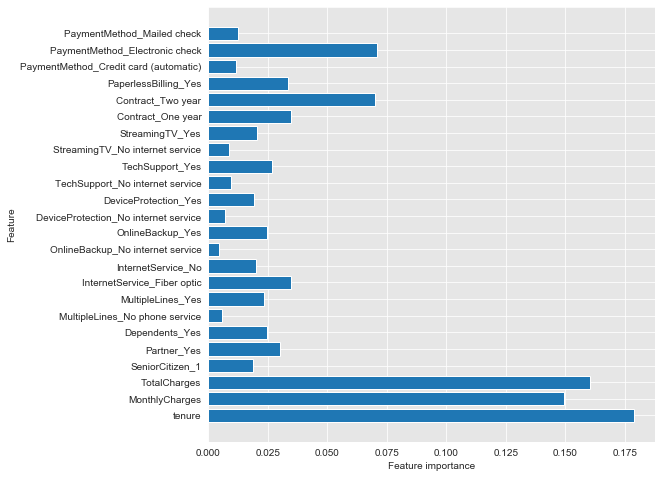

In [76]:
plot_feature_importances(clf)

# RANDOM FOREST  Grid search, not smoted, class_weight='balanced,  pipeline

In [77]:
pipe = Pipeline([('classifier', RandomForestClassifier(random_state=123))])

In [78]:
grid = [{'classifier__criterion': ['gini', 'entropy'], 
         'classifier__n_estimators':[10, 20, 50, 100, 150, 200],
         'classifier__max_depth': [3, 4, 5, 6, 7],
         'classifier__min_samples_split': [1.0, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
         'classifier__min_samples_leaf': [1,2, 3,4, 5,6,7, 8, 9, 10],
         'classifier__class_weight':['balanced']}]

In [79]:
clf = GridSearchCV(estimator= pipe, param_grid=grid, cv=5, scoring='roc_auc', n_jobs=-1 )

In [80]:
# Fit the training data
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [30]:
model_evaluation(X_train, X_test, y_train, y_test, y_pred_train, y_pred_test)

MODEL EVALUATION METRICS:
 -----------------------------------------------------
Confusion Matrix for train & test set: 

[[2936  927]
 [ 241 1170]] 

[[946 354]
 [101 357]]
-----------------------------------------------------

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.92      0.76      0.83      3863
           1       0.56      0.83      0.67      1411

    accuracy                           0.78      5274
   macro avg       0.74      0.79      0.75      5274
weighted avg       0.83      0.78      0.79      5274
 

Test set
               precision    recall  f1-score   support

           0       0.90      0.73      0.81      1300
           1       0.50      0.78      0.61       458

    accuracy                           0.74      1758
   macro avg       0.70      0.75      0.71      1758
weighted avg       0.80      0.74      0.76      1758

-------------------------------------------------

In [31]:
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.8772192820252397
0.8340888478333892


In [34]:
clf.best_params_

{'classifier__class_weight': 'balanced',
 'classifier__criterion': 'gini',
 'classifier__max_depth': 7,
 'classifier__min_samples_leaf': 9,
 'classifier__min_samples_split': 2,
 'classifier__n_estimators': 20}

# Bagging Classifier

In [ ]:
clf = BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), 
                                 n_estimators=20)

In [ ]:
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [ ]:
model_evaluation(X_train, X_test, y_train, y_test, y_pred_train, y_pred_test)

In [ ]:
roc_curve_and_auc(clf, X_train, X_test, y_train, y_test)

# Xgboost

In [86]:
clf = xgb.XGBClassifier()
clf.fit(scaled_X_train_smoted, y_train_smoted)
y_pred_train = clf.predict(scaled_X_train_smoted)
y_pred_test = clf.predict(scaled_X_test)

In [88]:
model_evaluation(scaled_X_train_smoted, scaled_X_test, y_train_smoted, y_test, y_pred_train, y_pred_test)

MODEL EVALUATION METRICS:
 -----------------------------------------------------
Confusion Matrix for train & test set: 

[[3199  664]
 [ 433 3430]] 

[[1032  268]
 [ 138  320]]
-----------------------------------------------------

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.88      0.83      0.85      3863
           1       0.84      0.89      0.86      3863

    accuracy                           0.86      7726
   macro avg       0.86      0.86      0.86      7726
weighted avg       0.86      0.86      0.86      7726
 

Test set
               precision    recall  f1-score   support

           0       0.88      0.79      0.84      1300
           1       0.54      0.70      0.61       458

    accuracy                           0.77      1758
   macro avg       0.71      0.75      0.72      1758
weighted avg       0.79      0.77      0.78      1758

---------------------------------------------

In [ ]:
# roc_curve_and_auc(clf, X_train, X_test, y_train, y_test)

In [ ]:
clf.feature_importances_.round(5)

In [ ]:
plot_feature_importances(clf)

# Gradient Boosting

In [ ]:
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [ ]:
model_evaluation(X_train, X_test, y_train, y_test, y_pred_train, y_pred_test)

In [ ]:
roc_curve_and_auc(clf, X_train, X_test, y_train, y_test)

In [ ]:
clf.feature_importances_.round(5)

In [ ]:
plot_feature_importances(clf)

# Adaboost

In [ ]:
clf = AdaBoostClassifier()
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [ ]:
model_evaluation(X_train, X_test, y_train, y_test, y_pred_train, y_pred_test)

In [ ]:
roc_curve_and_auc(clf, X_train, X_test, y_train, y_test)

In [ ]:
clf.feature_importances_

In [ ]:
plot_feature_importances(clf)

https://www.kaggle.com/stuarthallows/using-xgboost-with-scikit-learn